### Research Questions
1. How many of the files are valid BPMN2 XML files?
1. Do people use the diagram interchange format?
1. Which events are used?
  - Event types, e.g., intermediate, boundary, event sub-process, ...
  - Event definitions, e.g., timer events, conditional events, ...
1. How often are events fully specified, e.g., via formal expressions?
1. If formal expressions are given, how are they specified?

In [1]:
var fs = require('fs-extra');
var moddle = require('bpmn-moddle')();
var highcharts = require('highcharts-export-server');
var crypto = require('crypto');

In [2]:
var list;   // list of all files
var models; // list of all valid model files with their parsed BPMN model

In [3]:
// how many files to load at most
var LIMIT = undefined;
var DIR = './all_files/';

---
# 1. Loading
---

## Enumerate Files

List all the files we want to process.

In [4]:
$$.async();

fs.readdir(DIR).then(l => {
  if (LIMIT) {
    list = l.slice(0, LIMIT);
  } else {
    list = l;
  }
  console.log('Found', l.length, 'files and picked', list.length)
  $$.done();
});

Found 21306 files and picked 21306


## Remove Duplicates

We load all the files we have, even though some may not contain valid models.

We also filter duplicates by hashing each file, and detecting duplicate hashes.

In [5]:
var unique = {};
var loaded = [];
for (let i = 0; i < list.length; i++) {
  const fileName = list[i];
  const fileContent = fs.readFileSync(DIR + fileName, { encoding: 'utf8' });
  const hash = crypto.createHash('sha256').update(fileContent).digest('base64');
  if (unique[hash]) {
    continue;
  }
  loaded.push({
    fileName,
    fileContent
  });
  unique[hash] = true;
}
var duplicateCount = list.length - loaded.length;
console.log('Loaded', loaded.length, 'models, removed', duplicateCount, 'duplicates');

Loaded 10672 models, removed 10634 duplicates


## Parse Models

While parsing, we also filter invalid models.

In essence, we just throw the file contents at `bpmn-modle` and if that fails assume that the file did not contain a valid BPMN2 XML serialization.

In [27]:
$$.async();

var parseJobs = loaded.map(file => {
  return new Promise((resolve, reject) => {
    moddle.fromXML(file.fileContent, (error, definitions) => {
      if (!error) {
        resolve(definitions);
      } else {
        // return undefined for later filtering
        resolve();
      }
    });
  }).then(definitions => {
    if (definitions) {
      return {
        fileName: file.fileName,
        fileContent: file.fileContent,
        definitions
      };
    }
  });
});

var invalidCount;
Promise.all(parseJobs).then(results => {
  models = results.filter(Boolean);
  invalidCount = loaded.length - models.length;
  console.log('Parsed', models.length, 'models, removed', invalidCount, 'invalid');
  $$.done();
});

Parsed 8802 models, removed 1870 invalid


## Loading: Summary

- How many duplicates were detected?
- How many files contain valid BPMN2 models?

Found 10634 duplicates, 1870 invalid, 8802 valid


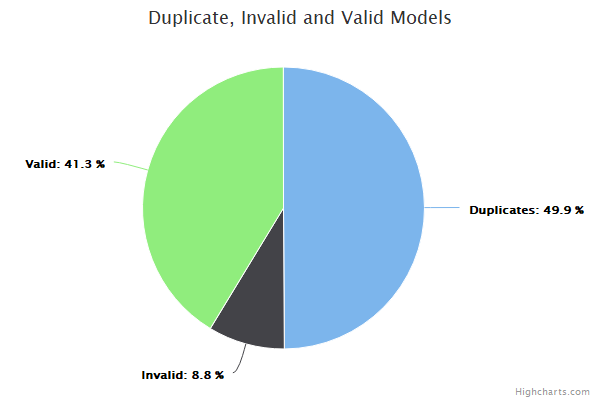

In [7]:
$$.async();

highcharts.initPool();

console.log('Found', duplicateCount, 'duplicates,', invalidCount, 'invalid,', models.length, 'valid');

var statPieChart = {
  type: 'png',
  options: {
    chart: {
      type: 'pie'
    },
    title: {
      text: 'Duplicate, Invalid and Valid Models'
    },
    plotOptions: {
      pie: {
        dataLabels: {
          enabled: true,
          format: '<b>{point.name}</b>: {point.percentage:.1f} %'
        }
      }
    },
    series: [{
      data: [{
        name: 'Duplicates',
        y: duplicateCount,
      }, {
        name: 'Invalid',
        y: invalidCount,
      }, {
        name: 'Valid',
        y: models.length,
      }]
    }]
  }
};

highcharts.export(statPieChart, function (err, res) {
  $$.png(res.data);
  highcharts.killPool();
  $$.done();
});

---
# 2. Element Usage
---

## Define Helper Functions

In [8]:
// traverse the containment tree of an element using a visitor
var traverse = (element, visitor) => {
  if (!element.$type && element.definitions) {
    // because I keep forgetting the .definitions
    element = element.definitions;
  }
  if (element.$instanceOf && visitor) {
    // visit only if we can check the type
    visitor(element);
  }
  if (element.$descriptor && element.$descriptor.properties) {
    element.$descriptor.properties.forEach(p => {
      if (element.hasOwnProperty(p.name) &&
          !p.isVirtual &&
          !p.isReference &&
          !p.isBody &&
          !p.isAttr)
      {
        const children = p.isMany ? element[p.name] : [ element[p.name] ];
        children.forEach(child => traverse(child, visitor));
      }
    });
  }
};

In [9]:
// collect all the elements of some specific types within a containment tree
var collectType = (element, ...types) => {
  let result = [];
  traverse(element, e => {
    if (types.some(type => e.$instanceOf(type))) {
      result.push(e);
    }
  });
  return result;
};

In [10]:
// return a list of the absolute and relative occurences of a specific
// type and its subtypes in all the models
var countByType = (type) => {
  let types = {};
  models.forEach(model => {
    let typeBloom = {};
    let typeCount = {};
    traverse(model, e => {
      if (!type || e.$instanceOf(type)) {
        typeBloom[e.$type] = true;
        typeCount[e.$type] = (typeCount[e.$type] || 0) + 1;
      }
    });

    // make sure we have all the keys in the total output
    for (let type in Object.assign({}, typeBloom, typeCount)) {
      types[type] = types[type] || [0, 0];
    }

    // add to totals
    for (let type in typeBloom) {
      types[type][0] += typeBloom[type];
    }
    for (let type in typeCount) {
      types[type][1] += typeCount[type];
    }
  });

  let sortable = [];
  for (let type in types) {
    //if (type.startsWith('bpmn:')) {
      sortable.push([type, ...types[type]]);
    //}
  }

  sortable.sort(function(a, b) {
    return b[1] - a[1];
  });
  return sortable;
}

## Occurence of Flow Elements
How often are specific flow elements used in valid models?

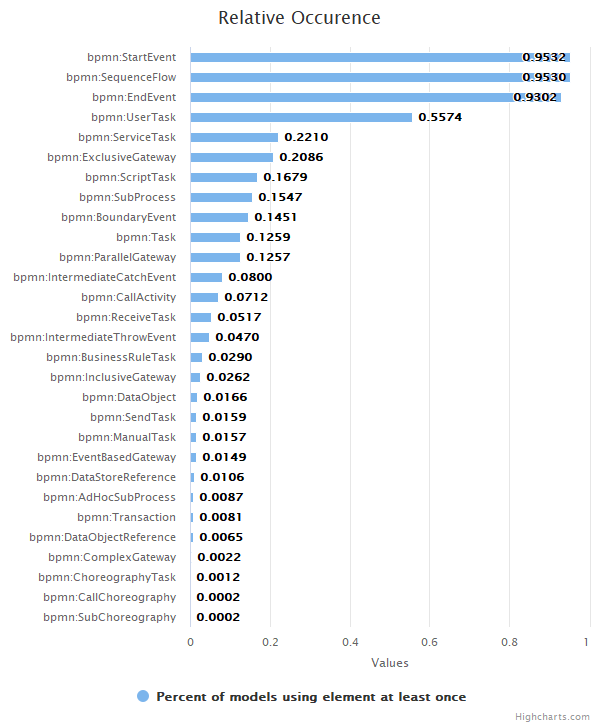

In [11]:
$$.async();

var counts = countByType('bpmn:FlowElement');

highcharts.initPool();

var relativeChart = {
  type: 'png',
  options: {
    chart: {
      type: 'bar',
      height: counts.length * 25
    },
    title: {
      text: 'Relative Occurence'
    },
    plotOptions: {
      bar: {
        dataLabels: {
          enabled: true,
          format: '<b>{point.y:.4f}</b>'
        }
      }
    },
    xAxis: {
      categories: counts.map(line => line[0])
    },
    yAxis: {
      max: 1
    },
    series: [{
      name: 'Percent of models using element at least once',
      data: counts.map(line => line[1] / models.length)
    }]
  }
};

highcharts.export(relativeChart, (err, res) => {
  $$.png(res.data);
  highcharts.killPool();
  $$.done();
});

## Event Types Used
Which event types are used?

In [12]:
var counts = countByType('bpmn:Event');
console.log(counts);

[
  [ 'bpmn:StartEvent', 8390, 10857 ],
  [ 'bpmn:EndEvent', 8188, 12737 ],
  [ 'bpmn:BoundaryEvent', 1277, 1916 ],
  [ 'bpmn:IntermediateCatchEvent', 704, 1210 ],
  [ 'bpmn:IntermediateThrowEvent', 414, 598 ]
]


In [13]:
var counts = countByType('bpmn:EventDefinition');
console.log(counts);

[
  [ 'bpmn:TerminateEventDefinition', 1008, 1241 ],
  [ 'bpmn:TimerEventDefinition', 859, 1145 ],
  [ 'bpmn:MessageEventDefinition', 649, 1256 ],
  [ 'bpmn:SignalEventDefinition', 564, 881 ],
  [ 'bpmn:ErrorEventDefinition', 462, 717 ],
  [ 'bpmn:CompensateEventDefinition', 216, 509 ],
  [ 'bpmn:EscalationEventDefinition', 146, 280 ],
  [ 'bpmn:ConditionalEventDefinition', 104, 163 ],
  [ 'bpmn:CancelEventDefinition', 72, 187 ],
  [ 'bpmn:LinkEventDefinition', 35, 79 ]
]


## Timer Events

In [22]:
var usesTimerEvents = models
  .map(model => collectType(model, 'bpmn:TimerEventDefinition'))
  .filter(elements => elements.length > 0)
  .length;
console.log(`${usesTimerEvents} of ${models.length} use timer events (${usesTimerEvents/models.length}\%)`);

859 of 8802 use timer events (0.09759145648716201%)


In [23]:
var defs = models
  .map(model => collectType(model.definitions, 'bpmn:TimerEventDefinition'))
  .flat();
var specs = { none: 0, timeDuration: 0, timeDate: 0, timeCycle: 0 };
defs.forEach(def => {
  if (def.timeDate) {
    specs.timeDate++;
  } else if (def.timeDuration) {
    specs.timeDuration++;
  } else if (def.timeCycle) {
    specs.timeCycle++;
  } else {
    specs.none++;
  }
})
console.log(specs);

{ none: 178, timeDuration: 655, timeDate: 79, timeCycle: 233 }


In [26]:
var bodies = defs
  .filter(def => def.timeDuration)
  .map(def => def.timeDuration.body);
console.log(Array.from(new Set(bodies)));

[
  'P1D',
  'PT2H',
  'PT10M',
  'PT2M',
  '${duration}',
  'PT1H',
  'PT3H',
  'PT3S',
  'PT5M',
  '${StartDate}/PT10S',
  'PT10S',
  'PT0S',
  'PT1M',
  'PT99H',
  'PT0H',
  'P10D',
  'PT1S',
  'P6M',
  'PT4H',
  'PT5S',
  '240s',
  'PT2S',
  'time is just a concept',
  'P0Y0M0DT0H0M05S',
  'PT10H',
  'PT5H',
  'P0Y0M0DT0H0M5S',
  'time is just an illusion',
  'PT${expiryDuration}S',
  'PT0M',
  'P14D',
  '${timerExpressionBean.getTimerDuration()}',
  'P5S',
  'PT30S',
  'PT30M',
  '${responseTimeOut_time}',
  'PT12H',
  'P20D',
  'PT7D',
  '${newsFlashTimerEnd}',
  '${newsFlashTimerStart}',
  '#{callbackAfter}',
  '#{timer}',
  '300',
  '2s',
  '500ms',
  '1s',
  '100',
  '1000',
  '10000',
  '5s',
  '5m',
  '4s',
  '3s',
  'abcdef',
  '500',
  '10s',
  '50m',
  '#{x}',
  '#{timeout}s',
  '250ms',
  '30d',
  'PT100S',
  'PT10s',
  'PT1H15M',
  'abc',
  'P4H',
  'MyTimeDurationValue',
  '4:10',
  '1:40',
  '11:40',
  'P0Y0M0DT0H0M6S',
  'P0Y0M0DT0H0M1S',
  'P0Y0M0DT0H0M2S',
  'plz w

In [38]:
var bodies = defs
  .filter(def => def.timeDate)
  .map(def => def.timeDate.body);
console.log(Array.from(new Set(bodies)));

[
  '#{dueDate}',
  "${'2036-11-14T11:12:22'}",
  '2036-11-14T11:12:22',
  '${duedate}',
  '#{innerVariable}',
  'PT10M',
  '${timerStartBean.cycle}',
  undefined,
  '2025-03-11T12:13:14',
  '#{date}',
  'abcdef',
  '2018-08-13T15:10:27+02:00',
  '2018-08-13T15:05:02+02:00',
  'abc',
  '201702081535',
  'myTimeDateValue',
  '2018-03-16T13:50:59+02:00',
  'plz continue tomorrow',
  '${iso8601PublishDate}',
  '${bpm_workflowDueDate}',
  '2012-11-12T20:44:00',
  '2009-04-20',
  "${execution.getVariable('demoTask.followUpDate')}",
  '${dateTimeHelper.dateToString(dateTime().withTimeAtStartOfDay().plusDays(1).plusHours(0).toDate())}',
  '${dateTimeHelper.getNextWorkingDate(dateTime().plusDays(1).toDate(),1,true)}',
  'DateTime.AddDays(Execution.Created, 1)',
  'scheduleTime',
  '${when}',
  '${sendAt}',
  '2017-04-05T22:58:00+08:00',
  '{$bestelldatum}',
  '#{DelayTime}',
  '${S(shiftInfo).prop("enddatetime").value()}',
  '${odate}',
  'PT5M',
  'PT1M',
  '2011-03-11T12:13:14Z',
  'date'
]


In [40]:
var bodies = defs
  .filter(def => def.timeCycle)
  .map(def => def.timeCycle.body);
console.log(Array.from(new Set(bodies)));

[
  'R/PT1H',
  'R20/PT2S',
  'R3/PT24H',
  '0/2 * * * * ?',
  '${timeCycle}',
  'R1/PT1H',
  'R3/P1D',
  'R10/PT24H/2025-12-12T00:00:05',
  'R10/PT24H',
  'R/PT2S',
  '0 0/5 * * * ?',
  'R2/PT5M',
  'R1/PT15S',
  '0/20 * * * * ?',
  'R3/PT5S',
  'R2/PT10S',
  '0 0/1 * * * ?',
  'R2/PT5S',
  'R10/PT2S',
  'R1/PT1H/${EndDateForCatch1}',
  'R1/PT1H/${EndDateForCatch2}',
  'R3/P7D',
  'R3/PT10H',
  'R/PT10S',
  '#{cycle}',
  'R10/PT10H',
  'R3/PT15S',
  'R3/PT20S',
  'R3/PT10M',
  'R3/${timestamp}/PT1S',
  '${cronExpression}',
  '15s',
  '500',
  '1m###1m',
  'R5/PT1S',
  '30s',
  '0/1 * * * * ?',
  '#{cronStr}',
  '500ms',
  '#{time}',
  'R2/PT1S',
  "'P2D'",
  '500ms###1s',
  '1s###1s',
  'R/PT1S',
  'R2/PT0.5S',
  '1000',
  '2000',
  'R2/PT2S',
  'R/PT30S',
  'R5/PT0.5S',
  '1000ms',
  '2s###1000ms',
  'R6/PT1S',
  '2s###4s',
  '1s',
  'abcdef',
  '1d###1d',
  'R10/PT1S',
  'R3/#{startTime}/PT3S',
  '1',
  '#{timer2}',
  '#{timer1}',
  '250ms',
  'R3/PT1S',
  '#{x}',
  'R/PT5S',
  '50m

## Conditional Events & Formal Expressions

In [17]:
var allFormalExpressions = models
  .map(model => collectType(model.definitions, 'bpmn:FormalExpression'))
  .flat()
  .map(expr => expr.body);
console.log(allFormalExpressions);

[
  '${!deptLeaderPass}',
  '${deptLeaderPass}',
  '${hrPass}',
  '${!hrPass}',
  '${reApply}',
  '${!reApply}',
  '${pass==1}',
  '${pass==1}',
  '${pass==0}',
  '${pass==1}',
  '${pass==1}',
  '${pass==1}',
  '${pass==0}',
  '${pass==0}',
  '${pass==0}',
  '${pass==0}',
  '${negotationFailed}',
  '${!negotationFailed}',
  '${consult=="no"}',
  '${consult=="yes"}',
  '${consult=="true"}',
  '${consult=="false"}',
  'PT3S',
  '${completed}',
  '${completed}',
  '${order.basic}',
  '${order.standard}',
  '${order.gold}',
  '${order.price <= 100}',
  '${order.price > 100 && order.price < 250}',
  '${order.price >= 250}',
  '${orders[1].price <= 100}',
  '${orders[1].price > 100 && orders[1].price < 250}',
  '${orders[1].price >= 250}',
  '${input == 1}',
  '${input == 3}',
  '${input == 1}',
  '${input == 2}',
  '${input == 3}',
  '${input == 1}',
  '${input == 2}',
  '${order.invalidMethod()}',
  '${order.isStandard()}',
  '${input == 1}',
  '${input == 1}',
  '${input == 1}',
  '${inpu

In [21]:
console.log(Array.from(new Set(allFormalExpressions)).splice(4000));

[
  '${flag == 0}',
  '${flag == 1}',
  'grievance',
  'Pending with #{roleType}',
  '_jbpm-unique-21_TaskNameInput',
  'Review by #{roleType}',
  '_jbpm-unique-21_NodeNameInput',
  'REVIEW_REQUEST',
  '_jbpm-unique-21_GroupIdInput',
  '#{empId}',
  'jasvinderbhomra@gmail.com',
  '_jbpm-unique-31_FromInput',
  'jasvinder.bhomra@abmindia.com',
  '_jbpm-unique-31_ToInput',
  'Request No:  #{document.requestNo} has been assigned to you.Please take necessary action.',
  '_jbpm-unique-31_BodyInput',
  'Request No:  #{document.requestNo} has been assigned to you.',
  '_jbpm-unique-31_SubjectInput',
  '_jbpm-unique-0_FromInput',
  '_jbpm-unique-0_ToInput',
  'Request No:  #{document.requestNo} has been approved and closed.',
  '_jbpm-unique-0_BodyInput',
  '_jbpm-unique-0_SubjectInput',
  '_jbpm-unique-9_FromInput',
  '_jbpm-unique-9_ToInput',
  'Request No:  #{document.requestNo} has been forwarded to you.Please take necessary action.',
  '_jbpm-unique-9_BodyInput',
  'Request No:  #{documen

---
---

In [41]:
var term = 'R3/PT8M3S';
var search = models
  .filter(model => model.fileContent.indexOf(term) >= 0)
  .map(model => model.fileName);
console.log(search);

[ '15748.bpmn', '15756.bpmn', '15840.bpmn' ]
